In [84]:
# Import Libraries

using DataFrames, CSV, Statistics, Plots

# Shelter Data

In [69]:
# Load data

df = select(CSV.read("shelters.csv", DataFrame; missingstring=["NA","NaN","N/A"]),
            r"^(CS_ID|Division|District|Upazila|Union|lon|lat|Shelter Name \(English\)|DRRO Capacity)$")
df = first(df, 163)
first(df, 1)

Row,CS_ID,Division,District,Upazila,Union,lon,lat,Shelter Name (English),DRRO Capacity
,String7,String15,String15,String7,String31,String15,String15,String,String7
1,CS_1,Chittagong,Cox'S Bazar,Teknaf,Teknaf Paurashava,92.29067798,20.85692678,Baitus Saraf muhammodia Riadul Jannah Dakil Madrasha,1000


In [70]:
# Fill missing values

col = Symbol("DRRO Capacity")

clean_number(x) = try
    # convert String7 → String
    s = String(x)

    # normalize (remove commas, trim spaces)
    s = replace(strip(s), "," => "")

    # treat empty or bad text as missing
    if isempty(s) || s in ["NA","N/A","na",".", "-", "--"]
        return missing
    end

    return parse(Float64, s)
catch
    missing
end

# 1. Convert entire column to Float64 or missing
df[!, col] = clean_number.(df[!, col])

# 2. Compute max
max_cap = maximum(skipmissing(df[!, col]))

# 3. Fill missing with max
df[!, col] = coalesce.(df[!, col], max_cap)

cols = [:lon, :lat]

for c in cols
    df[!, c] = passmissing(x -> parse(Float64, String(x))).(df[!, c])
end

# Union Data

In [71]:
# get union populations

df_unions = DataFrame(
    union = ["Teknaf", "Baharchhara", "Sabrang", "Whykong", "Nhilla", "St.Martin Dwip"],
    go_code = [63, 15, 47, 79, 31, 39],
    area = [25018, 3783, 16486, 31582, 17125, 835],
    latitude = [20.8667, 21.0611, 20.8182, 21.0998, 21.0148, 20.6131],
    longitude = [92.3, 92.1526, 92.3069, 92.1674, 92.2453, 92.3267],
    male_pop = [24076, 14481, 29126, 31582, 17125, 835],
    female_pop = [23632, 14324, 29232, 25567, 23536, 3232],
    literacy_rate = [31.1, 22.6, 16.9, 28.0, 28.5, 18.6]
)


Row,union,go_code,area,latitude,longitude,male_pop,female_pop,literacy_rate
,String,Int64,Int64,Float64,Float64,Int64,Int64,Float64
1,Teknaf,63,25018,20.8667,92.3,24076,23632,31.1
2,Baharchhara,15,3783,21.0611,92.1526,14481,14324,22.6
3,Sabrang,47,16486,20.8182,92.3069,29126,29232,16.9
4,Whykong,79,31582,21.0998,92.1674,31582,25567,28.0
5,Nhilla,31,17125,21.0148,92.2453,17125,23536,28.5
6,St.Martin Dwip,39,835,20.6131,92.3267,835,3232,18.6


In [72]:
# First, make the column names match
rename!(df, Symbol("Union") => :union)

# Now perform the join
df_merged = leftjoin(df, df_unions, on = :union)

first(df_merged, 1)

Row,CS_ID,Division,District,Upazila,union,lon,lat,Shelter Name (English),DRRO Capacity,go_code,area,latitude,longitude,male_pop,female_pop,literacy_rate
,String7,String15,String15,String7,String31,Float64,Float64,String,Float64,Int64?,Int64?,Float64?,Float64?,Int64?,Int64?,Float64?
1,CS_10,Chittagong,Cox'S Bazar,Teknaf,Sabrang,92.3322,20.7607,Sahaporirdip Dakkin para Center,1000.0,47,16486,20.8182,92.3069,29126,29232,16.9


In [73]:
# Drop the 'division' column (case-sensitive)
select!(df_merged, Not(:Division))

# Lowercase all String / String7 columns
for c in names(df_merged)
    if eltype(df_merged[!, c]) <: AbstractString
        df_merged[!, c] = lowercase.(String.(df_merged[!, c]))
    end
end

first(df_merged, 1)

Row,CS_ID,District,Upazila,union,lon,lat,Shelter Name (English),DRRO Capacity,go_code,area,latitude,longitude,male_pop,female_pop,literacy_rate
,String,String,String,String,Float64,Float64,String,Float64,Int64?,Int64?,Float64?,Float64?,Int64?,Int64?,Float64?
1,cs_10,cox's bazar,teknaf,sabrang,92.3322,20.7607,sahaporirdip dakkin para center,1000.0,47,16486,20.8182,92.3069,29126,29232,16.9


# Grid

In [77]:
# make the grid

lat = df_merged.lat
lon = df_merged.lon

# Compute bounding box of Cox's Bazar shelters
lat_min = minimum(skipmissing(lat))
lat_max = maximum(skipmissing(lat))

lon_min = minimum(skipmissing(lon))
lon_max = maximum(skipmissing(lon))

# Add ~10 km padding in all directions
km = 1
deg1km_lat = 0.008993               # km to degrees latitude
deg1km_lon = 0.008993 * cosd(21)    # degrees longitude at Cox's Bazar latitude

lat_pad = 10 * deg1km_lat
lon_pad = 10 * deg1km_lon

lat_min -= lat_pad
lat_max += lat_pad
lon_min -= lon_pad
lon_max += lon_pad

# Generate grid steps (1 km)
lat_step = deg1km_lat
lon_step = deg1km_lon

lat_bins = collect(lat_min:lat_step:lat_max)
lon_bins = collect(lon_min:lon_step:lon_max)

# Convert bins to centers
lat_centers = lat_bins .+ lat_step/2
lon_centers = lon_bins .+ lon_step/2

# Create full grid (Cartesian product)
grid = DataFrame(
    lat_center = repeat(lat_centers, inner=length(lon_centers)),
    lon_center = repeat(lon_centers, outer=length(lat_centers))
)

# Add grid IDs
grid.lat_bin = repeat(1:length(lat_centers), inner=length(lon_centers))
grid.lon_bin = repeat(1:length(lon_centers), outer=length(lat_centers))
grid.grid_id = string.(grid.lat_bin, "_", grid.lon_bin)

first(grid, 5)

Row,lat_center,lon_center,lat_bin,lon_bin,grid_id
,Float64,Float64,Int64,Int64,String
1,20.5471,91.9692,1,1,1_1
2,20.5471,91.9776,1,2,1_2
3,20.5471,91.986,1,3,1_3
4,20.5471,91.9944,1,4,1_4
5,20.5471,92.0028,1,5,1_5


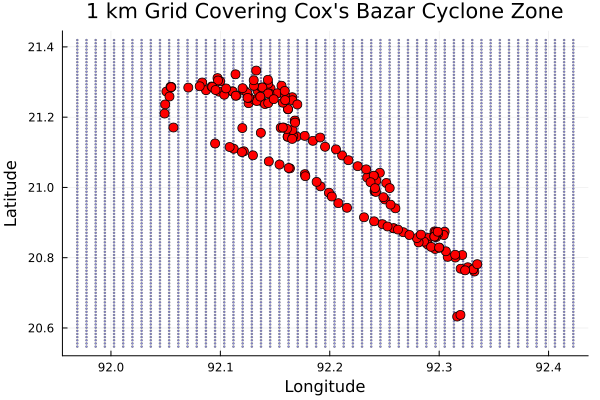

In [81]:
# plot the grid and shelters

scatter(
    grid.lon_center, grid.lat_center,
    markersize = 1, alpha = 0.4, legend = false,
    title = "1 km Grid Covering Cox's Bazar Cyclone Zone",
    xlabel = "Longitude", ylabel = "Latitude",
    color = :blue, label = "Grid cells"
)

scatter!(
    df.lon, df.lat,
    markersize = 5, color = :red, label = "Shelters"
)


In [85]:
CSV.write("grid.csv", grid)
CSV.write("shelter_data.csv", df_merged)

"shelter_data.csv"